In [4]:
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the noise predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

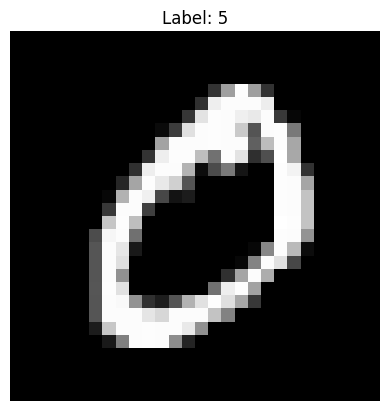

In [6]:

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image
first_image = x_train[0]

# Display the first image
plt.imshow(first_image, cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [8]:
type(y_train[0])

numpy.uint8

In [54]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image and normalize it to [0, 1]
image = (x_train[0] / 255.0) * 2 - 1

# Define alpha and beta# scaling factor
beta = 0.2  # noise scaling factor
alpha = np.sqrt(1-beta)
beta = np.sqrt(beta)

# Initialize x_t with the original image
x_t = image

# Number of steps
num_steps = 100

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 4 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Generate Gaussian noise with mean 0.5 and standard deviation 0.1
    noise = np.random.normal(0, 0.2, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')

    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(beta * noise, cmap='gray')
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist((noise).flatten(), bins=50, density=True, alpha=0.75, color='red')
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

Initial Image - Step 0, Top-Left Pixel Value: -1.0000
Step 1 - Noisy Image, Top-Left Pixel Value: -0.9145
Step 1 - Added Noise, Top-Left Pixel Value: -0.0200
Step 2 - Noisy Image, Top-Left Pixel Value: -0.8719
Step 2 - Added Noise, Top-Left Pixel Value: -0.0540
Step 3 - Noisy Image, Top-Left Pixel Value: -0.8054
Step 3 - Added Noise, Top-Left Pixel Value: -0.0256
Step 4 - Noisy Image, Top-Left Pixel Value: -0.4734
Step 4 - Added Noise, Top-Left Pixel Value: 0.2471
Step 5 - Noisy Image, Top-Left Pixel Value: -0.4166
Step 5 - Added Noise, Top-Left Pixel Value: 0.0068
Step 6 - Noisy Image, Top-Left Pixel Value: -0.3859
Step 6 - Added Noise, Top-Left Pixel Value: -0.0133
Step 7 - Noisy Image, Top-Left Pixel Value: -0.3869
Step 7 - Added Noise, Top-Left Pixel Value: -0.0417
Step 8 - Noisy Image, Top-Left Pixel Value: -0.2708
Step 8 - Added Noise, Top-Left Pixel Value: 0.0752
Step 9 - Noisy Image, Top-Left Pixel Value: -0.2426
Step 9 - Added Noise, Top-Left Pixel Value: -0.0004
Step 10 - Noi

Initial Image - Step 0, Top-Left Pixel Value: -1.0000
Step 1 - Noisy Image, Top-Left Pixel Value: -0.9796
Step 1 - Added Noise, Top-Left Pixel Value: 0.0154
Step 2 - Noisy Image, Top-Left Pixel Value: -0.9469
Step 2 - Added Noise, Top-Left Pixel Value: 0.0248
Step 3 - Noisy Image, Top-Left Pixel Value: -0.9370
Step 3 - Added Noise, Top-Left Pixel Value: -0.0005
Step 4 - Noisy Image, Top-Left Pixel Value: -0.9407
Step 4 - Added Noise, Top-Left Pixel Value: -0.0167
Step 5 - Noisy Image, Top-Left Pixel Value: -0.8814
Step 5 - Added Noise, Top-Left Pixel Value: 0.0433
Step 6 - Noisy Image, Top-Left Pixel Value: -0.8179
Step 6 - Added Noise, Top-Left Pixel Value: 0.0458
Step 7 - Noisy Image, Top-Left Pixel Value: -0.7802
Step 7 - Added Noise, Top-Left Pixel Value: 0.0189
Step 8 - Noisy Image, Top-Left Pixel Value: -0.7321
Step 8 - Added Noise, Top-Left Pixel Value: 0.0278
Step 9 - Noisy Image, Top-Left Pixel Value: -0.6582
Step 9 - Added Noise, Top-Left Pixel Value: 0.0525
Step 10 - Noisy I

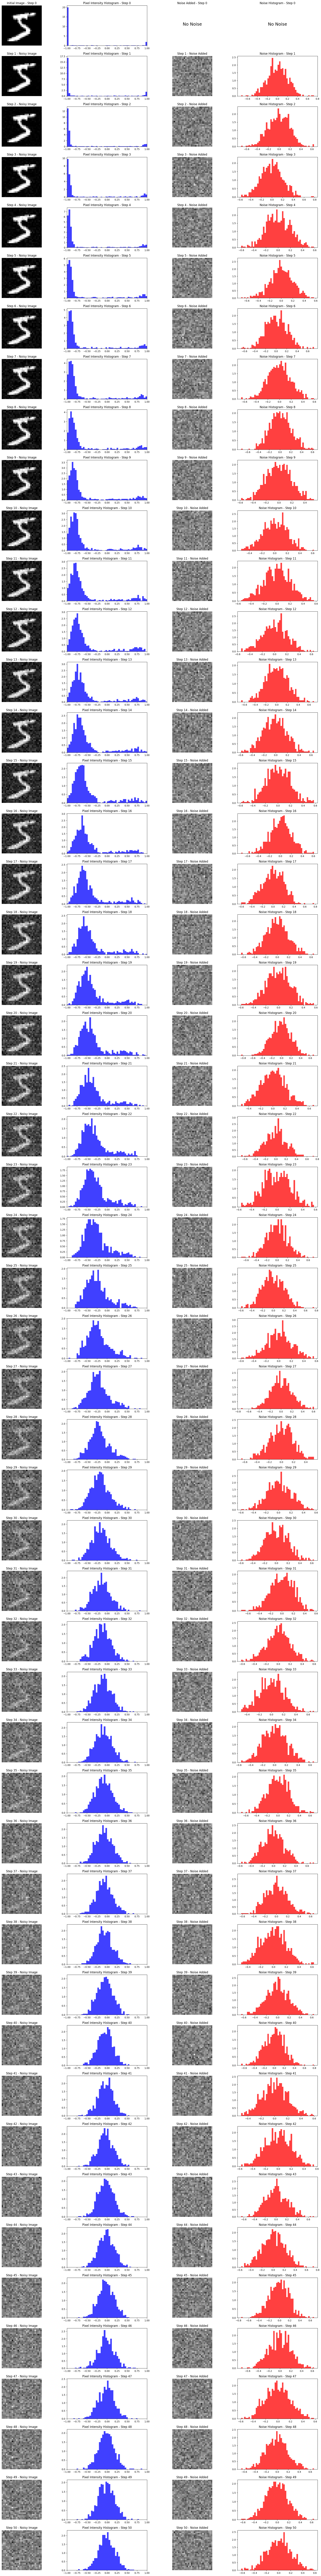

In [66]:

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image and normalize it to [-1, 1]
image = (x_train[0] / 255.0) * 2 - 1

# Number of steps
num_steps = 50

# Define the linear scheduler for beta
beta_min = 0.01
beta_max = 0.3
betas = np.linspace(beta_min, beta_max, num_steps)

# Initialize x_t with the original image
x_t = image

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 3 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray', vmin=-1, vmax=1)
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Set alpha and beta for the current step
    beta_t = betas[t - 1]
    alpha = np.sqrt(1 - beta_t)
    beta = np.sqrt(beta_t)
    
    # Generate Gaussian noise with mean 0 and standard deviation 1
    noise = np.random.normal(0, 0.2, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')
    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(noise, cmap='gray', vmin=-1, vmax=1)
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist(noise.flatten(), bins=50, density=True, alpha=0.75, color='red')
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

# Define the U-Net model architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # Downsampling path
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        # Upsampling path
        x = self.up1(x4)

        # Skip connections
        x3_resized = F.interpolate(x3, size=x.shape[2:])
        x = self.up2(x + x3_resized)

        x2_resized = F.interpolate(x2, size=x.shape[2:])
        x = self.up3(x + x2_resized)

        x1_resized = F.interpolate(x1, size=x.shape[2:])
        x = self.up4(x + x1_resized)

        return x

# Define the diffusion model
class DiffusionModel(nn.Module):
    def __init__(self, model, T=50, beta_min=0.01, beta_max=0.1, device='mps'):
        super(DiffusionModel, self).__init__()
        self.model = model
        self.T = T
        self.device = device
        # Custom beta schedule
        self.betas = torch.linspace(beta_min, beta_max, T).to(self.device)

    def q_sample(self, x_start, t):
        noise = torch.randn_like(x_start) * sigma + mu  # Use mu and sigma for noise
        sqrt_alpha = (1 - self.betas).cumprod(dim=0)[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = (1 - (1 - self.betas).cumprod(dim=0)[t]).view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise

    def forward(self, x_start, t):
        x_t = self.q_sample(x_start, t)
        return self.model(x_t)

# Training function
def train(model, device, train_loader, optimizer, T):
    model.train()
    mse_loss = nn.MSELoss()
    for epoch in range(5):  # Train for 5 epochs
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            t = torch.randint(0, T, (data.size(0),), device=device).long()
            optimizer.zero_grad()

            noise_pred = model(data, t)

            # Resize noise_pred to match the size of data if necessary
            if noise_pred.shape != data.shape:
                noise_pred = F.interpolate(noise_pred, size=data.shape[2:])

            noise_true = torch.randn_like(data) * sigma + mu  # Use mu and sigma for noise
            loss = mse_loss(noise_pred, noise_true)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch} [Batch: {batch_idx}/{len(train_loader)}]\tLoss: {loss.item()}')


In [54]:
# Parameters
T = 500
beta_min = 0.0001
beta_max = 0.02
mu = 0
sigma = 0.2

# Setup device and data
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Rescale images to [-1, 1]
])

train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform),
                          batch_size=64, shuffle=True)

# Initialize model and optimizer
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train(model, device, train_loader, optimizer, T=T)

# Save the model after training
torch.save(model.state_dict(), 'diffusion_model_mnist.pth')

Using device: mps
Epoch: 0 [Batch: 0/938]	Loss: 0.17580191791057587
Epoch: 0 [Batch: 100/938]	Loss: 0.06717254221439362
Epoch: 0 [Batch: 200/938]	Loss: 0.0586523711681366
Epoch: 0 [Batch: 300/938]	Loss: 0.05477753281593323
Epoch: 0 [Batch: 400/938]	Loss: 0.05079484358429909
Epoch: 0 [Batch: 500/938]	Loss: 0.0488772876560688
Epoch: 0 [Batch: 600/938]	Loss: 0.048388537019491196
Epoch: 0 [Batch: 700/938]	Loss: 0.0471845306456089
Epoch: 0 [Batch: 800/938]	Loss: 0.04545610025525093
Epoch: 0 [Batch: 900/938]	Loss: 0.04509425535798073
Epoch: 1 [Batch: 0/938]	Loss: 0.044664692133665085
Epoch: 1 [Batch: 100/938]	Loss: 0.044842202216386795
Epoch: 1 [Batch: 200/938]	Loss: 0.04376872628927231
Epoch: 1 [Batch: 300/938]	Loss: 0.043300408869981766
Epoch: 1 [Batch: 400/938]	Loss: 0.04340923950076103
Epoch: 1 [Batch: 500/938]	Loss: 0.04323302209377289
Epoch: 1 [Batch: 600/938]	Loss: 0.04297880083322525
Epoch: 1 [Batch: 700/938]	Loss: 0.04253694787621498
Epoch: 1 [Batch: 800/938]	Loss: 0.042259935289621

In [55]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Train the model
train(model, device, train_loader, optimizer, T=T)

# Save the model after training
torch.save(model.state_dict(), 'diffusion_model_mnist.pth')

Epoch: 0 [Batch: 0/938]	Loss: 0.03996407985687256
Epoch: 0 [Batch: 100/938]	Loss: 0.04077089577913284
Epoch: 0 [Batch: 200/938]	Loss: 0.04015548899769783
Epoch: 0 [Batch: 300/938]	Loss: 0.04025556892156601
Epoch: 0 [Batch: 400/938]	Loss: 0.040329232811927795
Epoch: 0 [Batch: 500/938]	Loss: 0.040398962795734406
Epoch: 0 [Batch: 600/938]	Loss: 0.04057729244232178
Epoch: 0 [Batch: 700/938]	Loss: 0.04014379158616066
Epoch: 0 [Batch: 800/938]	Loss: 0.040399082005023956
Epoch: 0 [Batch: 900/938]	Loss: 0.04067419096827507
Epoch: 1 [Batch: 0/938]	Loss: 0.040383998304605484
Epoch: 1 [Batch: 100/938]	Loss: 0.04064615070819855
Epoch: 1 [Batch: 200/938]	Loss: 0.04038815572857857
Epoch: 1 [Batch: 300/938]	Loss: 0.0401843823492527
Epoch: 1 [Batch: 400/938]	Loss: 0.040568429976701736
Epoch: 1 [Batch: 500/938]	Loss: 0.04075803607702255
Epoch: 1 [Batch: 600/938]	Loss: 0.04078919067978859
Epoch: 1 [Batch: 700/938]	Loss: 0.04030372574925423
Epoch: 1 [Batch: 800/938]	Loss: 0.040421079844236374
Epoch: 1 [B

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_21591/2178303941.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('diffusion_m

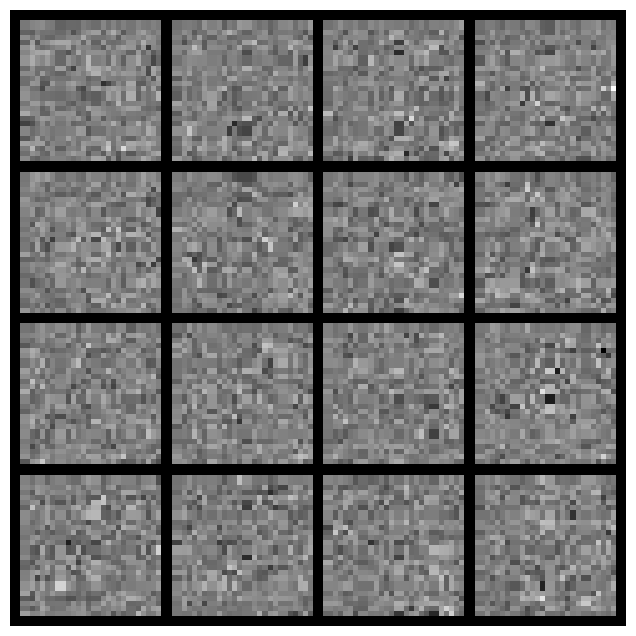

In [56]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Reload the model for sampling with the same parameters
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
model.load_state_dict(torch.load('diffusion_model_mnist.pth'))

# Sampling Loop
def sample_and_plot(model, device, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Start with Gaussian noise with mean = mu and std = sigma
        x = torch.randn(num_samples, 1, 28, 28, device=device) * sigma + mu
        for t in reversed(range(model.T)):
            noise = torch.randn_like(x) * sigma + mu if t > 0 else torch.zeros_like(x)
            x_model = model.model(x)
            
            # Resize x_model to match the size of x if necessary
            if x_model.shape != x.shape:
                x_model = F.interpolate(x_model, size=x.shape[2:])
            
            x = x_model + noise
        
        # Plot the sampled images
        x = x.cpu()
        save_image(x, f'generated_samples.png', nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread('generated_samples.png'))
        plt.axis('off')
        plt.show()

# Generate and plot samples
sample_and_plot(model, device)

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_21591/900940615.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('diffusion_mo

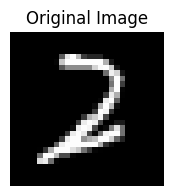

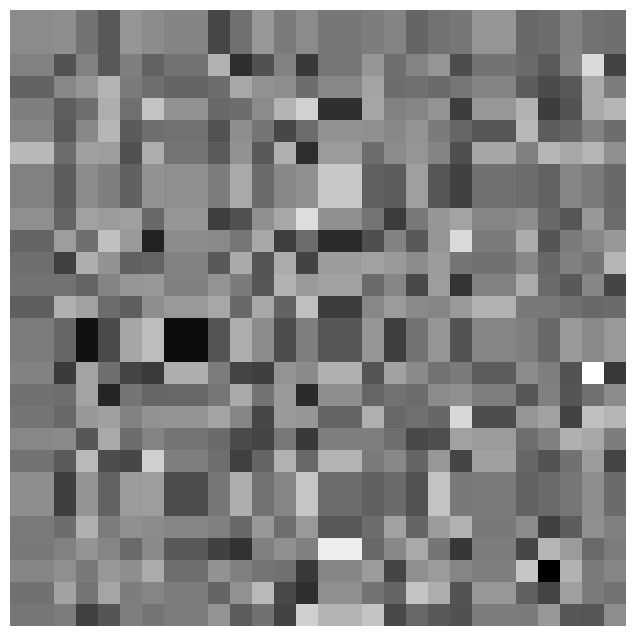

In [53]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Reload the model for sampling with the same parameters
model = DiffusionModel(UNet(), T=T, beta_min=beta_min, beta_max=beta_max, device=device).to(device)
model.load_state_dict(torch.load('diffusion_model_mnist.pth'))

# Sampling Loop using an image from the dataset
def sample_and_plot(model, device, data_loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        # Get an image from the dataset
        data_iter = iter(data_loader)
        real_image, _ = next(data_iter)
        real_image = real_image[:num_samples].to(device)  # Select the first image and normalize it to [-1, 1]

        # Plot the original image
        plt.figure(figsize=(2, 2))
        plt.imshow(real_image[0].cpu().squeeze(), cmap='gray', vmin=-1, vmax=1)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        # Initialize x with the real image
        x = real_image.clone()

        # Apply the diffusion process in reverse
        for t in reversed(range(model.T)):
            noise = torch.randn_like(x) * sigma + mu if t > 0 else torch.zeros_like(x)
            x_model = model.model(x)
            
            # Resize x_model to match the size of x if necessary
            if x_model.shape != x.shape:
                x_model = F.interpolate(x_model, size=x.shape[2:])
            
            x = x_model + noise
        
        # Plot the sampled images
        x = x.cpu()
        save_image(x, f'generated_samples_from_real_image.png', nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(plt.imread('generated_samples_from_real_image.png'))
        plt.axis('off')
        plt.show()

# Generate and plot samples using an image from the dataset
sample_and_plot(model, device, train_loader)

Initial Image - Step 0, Top-Left Pixel Value: -1.0000
Step 1 - Noisy Image, Top-Left Pixel Value: -1.0409
Step 1 - Added Noise, Top-Left Pixel Value: -0.0460
Step 2 - Noisy Image, Top-Left Pixel Value: -1.0421
Step 2 - Added Noise, Top-Left Pixel Value: -0.0073
Step 3 - Noisy Image, Top-Left Pixel Value: -1.0600
Step 3 - Added Noise, Top-Left Pixel Value: -0.0250
Step 4 - Noisy Image, Top-Left Pixel Value: -1.0434
Step 4 - Added Noise, Top-Left Pixel Value: 0.0083
Step 5 - Noisy Image, Top-Left Pixel Value: -1.0238
Step 5 - Added Noise, Top-Left Pixel Value: 0.0106
Step 6 - Noisy Image, Top-Left Pixel Value: -0.9892
Step 6 - Added Noise, Top-Left Pixel Value: 0.0247
Step 7 - Noisy Image, Top-Left Pixel Value: -0.9644
Step 7 - Added Noise, Top-Left Pixel Value: 0.0143
Step 8 - Noisy Image, Top-Left Pixel Value: -0.9439
Step 8 - Added Noise, Top-Left Pixel Value: 0.0094
Step 9 - Noisy Image, Top-Left Pixel Value: -0.9195
Step 9 - Added Noise, Top-Left Pixel Value: 0.0127
Step 10 - Noisy 

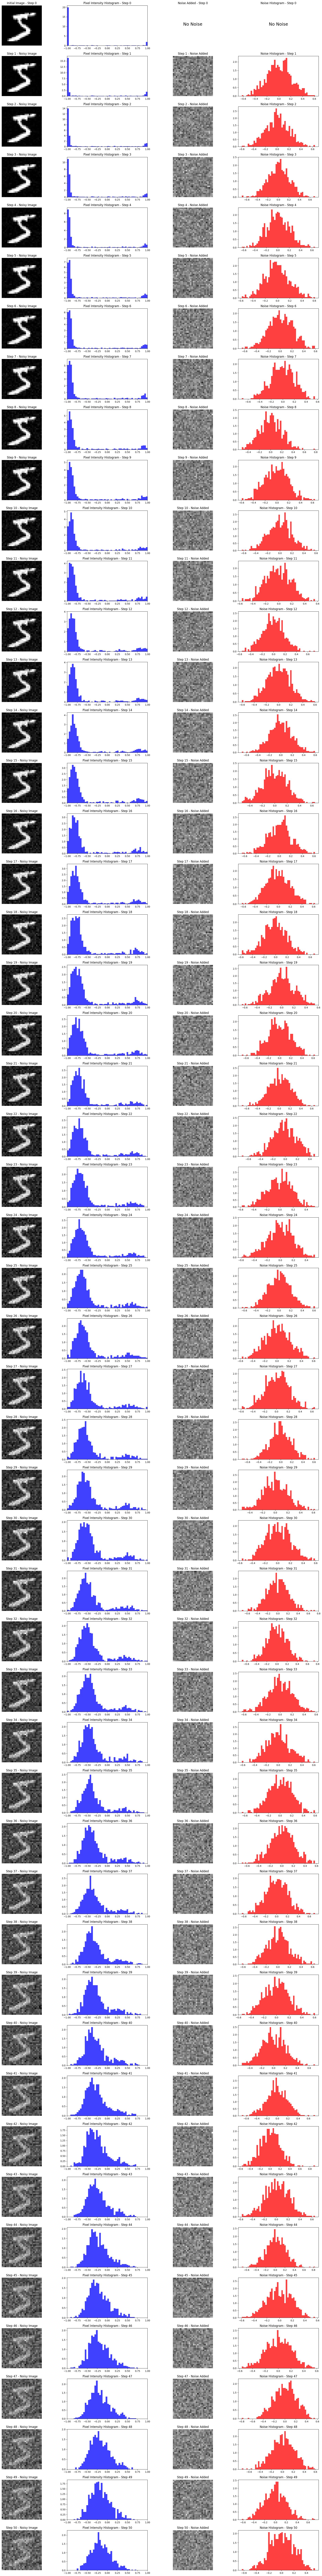

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Select the first image and normalize it to [-1, 1]
image = (x_train[0] / 255.0) * 2 - 1

# Number of steps
num_steps = 50

# Define the linear scheduler for beta
beta_min = 0.01
beta_max = 0.1
betas = np.linspace(beta_min, beta_max, num_steps)

# Initialize x_t with the original image
x_t = image

# Plotting the initial image, the progression of noise addition, noise maps, and noise histograms
fig, axes = plt.subplots(num_steps + 1, 4, figsize=(20, 3 * num_steps))

# Print the top-left pixel value of the initial image
print(f"Initial Image - Step 0, Top-Left Pixel Value: {image[0, 0]:.4f}")

# Plot the initial image
axes[0, 0].imshow(image, cmap='gray', vmin=-1, vmax=1)
axes[0, 0].set_title('Initial Image - Step 0')
axes[0, 0].axis('off')

# Plot the histogram of pixel intensities for the initial image
axes[0, 1].hist(image.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
axes[0, 1].set_xlim([-1, 1])
axes[0, 1].set_title('Pixel Intensity Histogram - Step 0')

# No noise added for the initial image
axes[0, 2].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 2].set_title('Noise Added - Step 0')
axes[0, 2].axis('off')

# No noise histogram for the initial image
axes[0, 3].text(0.5, 0.5, 'No Noise', fontsize=18, ha='center')
axes[0, 3].set_title('Noise Histogram - Step 0')
axes[0, 3].axis('off')

for t in range(1, num_steps + 1):
    # Set alpha and beta for the current step
    beta_t = betas[t - 1]
    alpha = np.sqrt(1 - beta_t)
    beta = np.sqrt(beta_t)
    
    # Generate Gaussian noise with mean 0 and standard deviation 0.2
    noise = np.random.normal(0, 0.2, image.shape)
    
    # Update x_t using the equation
    x_t = x_t * alpha + beta * noise
    
    # Print the top-left pixel values for the noisy image and the added noise
    print(f"Step {t} - Noisy Image, Top-Left Pixel Value: {x_t[0, 0]:.4f}")
    print(f"Step {t} - Added Noise, Top-Left Pixel Value: {(beta * noise)[0, 0]:.4f}")
    
    # Plot the image at step t
    axes[t, 0].imshow(x_t, cmap='gray', vmin=-1, vmax=1)
    axes[t, 0].set_title(f'Step {t} - Noisy Image')
    axes[t, 0].axis('off')
    
    # Plot the histogram of pixel intensities
    axes[t, 1].hist(x_t.flatten(), bins=50, range=(-1, 1), density=True, alpha=0.75, color='blue')
    axes[t, 1].set_xlim([-1, 1])
    axes[t, 1].set_title(f'Pixel Intensity Histogram - Step {t}')
    
    # Plot the noise map
    axes[t, 2].imshow(noise, cmap='gray', vmin=-1, vmax=1)
    axes[t, 2].set_title(f'Step {t} - Noise Added')
    axes[t, 2].axis('off')

    # Plot the histogram of the noise
    axes[t, 3].hist(noise.flatten(), bins=50, density=True, alpha=0.75, color='red')
    axes[t, 3].set_title(f'Noise Histogram - Step {t}')

plt.tight_layout()
plt.show()

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_time_embedding(time_steps, temb_dim):
    device = time_steps.device  # Ensure everything is on the same device
    factor = 10000 ** (torch.arange(temb_dim // 2, dtype=torch.float32, device=device) / (temb_dim // 2))
    t_emb = time_steps[:, None].float() / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.temb_proj = nn.Linear(temb_dim, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.silu = nn.SiLU()
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, temb):
        h = self.silu(self.norm1(x))
        h = self.conv1(h)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.silu(self.norm2(h))
        h = self.conv2(h)
        return h + self.res_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.attn = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x).reshape(b, c, h * w).transpose(1, 2)
        h, _ = self.attn(x_norm, x_norm, x_norm)
        h = h.transpose(1, 2).reshape(b, c, h, w)
        return self.proj_out(h) + x

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_dim, down_sample=True):
        super().__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, temb_dim)
        self.attn_block = AttentionBlock(out_channels)
        self.down_sample = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1) if down_sample else nn.Identity()

    def forward(self, x, temb):
        x = self.res_block(x, temb)
        x = self.attn_block(x)
        x = self.down_sample(x)
        return x

class MidBlock(nn.Module):
    def __init__(self, channels, temb_dim):
        super().__init__()
        self.res_block1 = ResidualBlock(channels, channels, temb_dim)
        self.attn_block = AttentionBlock(channels)
        self.res_block2 = ResidualBlock(channels, channels, temb_dim)

    def forward(self, x, temb):
        x = self.res_block1(x, temb)
        x = self.attn_block(x)
        x = self.res_block2(x, temb)
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_dim, up_sample=True):
        super().__init__()
        self.res_block = ResidualBlock(in_channels, out_channels, temb_dim)
        self.attn_block = AttentionBlock(out_channels)
        self.up_sample = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1) if up_sample else nn.Identity()

    def forward(self, x, temb, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.res_block(x, temb)
        x = self.attn_block(x)
        x = self.up_sample(x)
        return x

class UNet(nn.Module):
    def __init__(self, im_channels=1, temb_dim=128):
        super().__init__()
        self.temb_dim = temb_dim

        # Time embedding projection
        self.temb_proj = nn.Sequential(
            nn.Linear(temb_dim, temb_dim),
            nn.SiLU(),
            nn.Linear(temb_dim, temb_dim)
        )

        # Downsampling path
        self.conv_in = nn.Conv2d(im_channels, 32, kernel_size=3, padding=1)
        self.down1 = DownBlock(32, 64, temb_dim)
        self.down2 = DownBlock(64, 128, temb_dim)
        self.down3 = DownBlock(128, 256, temb_dim, down_sample=False)

        # Middle block
        self.mid = MidBlock(256, temb_dim)

        # Upsampling path
        self.up3 = UpBlock(256 + 128, 128, temb_dim)
        self.up2 = UpBlock(128 + 64, 64, temb_dim)
        self.up1 = UpBlock(64 + 32, 32, temb_dim, up_sample=False)

        self.conv_out = nn.Conv2d(32, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        temb = get_time_embedding(t, self.temb_dim)
        temb = self.temb_proj(temb)

        # Downsample
        x1 = self.conv_in(x)
        x2 = self.down1(x1, temb)
        x3 = self.down2(x2, temb)
        x4 = self.down3(x3, temb)

        # Middle
        x_mid = self.mid(x4, temb)

        # Upsample
        x = self.up3(x_mid, temb, x3)
        x = self.up2(x, temb, x2)
        x = self.up1(x, temb, x1)

        x = self.conv_out(x)
        return x

In [45]:
# Initialize the modified model
model = UNet(im_channels=1, temb_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train(model, device, train_loader, optimizer, T=T)

# Save the model after training
torch.save(model.state_dict(), 'diffusion_model_mnist.pth')

# Sample and plot
sample_and_plot(model, device, train_loader)

TypeError: reshape(): argument 'shape' failed to unpack the object at pos 3 with error "type must be tuple of ints,but got Tensor"